In [24]:
import os
import cv2
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from metrics import top_3_acc
from os import listdir
from PIL import Image, ImageFile
import pdb
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn import metrics
import pylab as pl
import keras.backend as K
from keras.models import *
from keras.callbacks import *
import tensorflow as tf
import keras
from keras.layers.core import Lambda

%matplotlib inline

In [103]:
from keras.models import model_from_json
json_file = open('../models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("../models/weights_ep04.hd5f")
print("Loaded model from disk")

Loaded model from disk


In [151]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 25
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    loss = K.sum(model.layers[-1].output)

    #conv_output = [l for l in model.layers[0].layers if l.name is layer_name][0].output
    conv_output = [l for l in model.layers if l.name == layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (261, 229))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap


In [172]:
input_size = (261, 229)
img_path = "/home/bartol/Work/mozgalo-mb/src/data/test/Other/2008.jpg"

preprocessed_input = load_image(cv2.imread(img_path))


predictions = model.predict(preprocessed_input)


predicted_class = np.argmax(predictions)

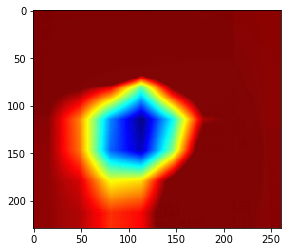

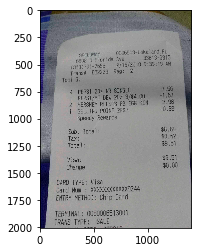

In [173]:

cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block14_sepconv2_act")
#cv2.imwrite("gradcam.jpg", cam)
plt.imshow(cam)
plt.show()
plt.imshow(cv2.imread(img_path))
plt.show()